In [1]:
import pandas as pd
import os

In [2]:
from train_test_split import get_model_input
input = get_model_input(method = 'random', num_train = 5, num_test = 1)
model_input = input[0]

/home/prompt5398/LLM/src
X_train shape: (3915, 1)
X_test shape: (435, 1)
y_train shape: (3915,)
y_test shape: (435,)


In [3]:
print(model_input)


    You are a strict SQL translator. 

    You MUST ONLY output a single SQL query. 

    You are NOT allowed to repeat the instructions, the examples, or any natural language text. 

    You CANNOT explain anything. 

    You MUST copy the style of the EXAMPLES exactly.

    Respond ONLY with the SQL query.
    
---

    [EXAMPLE NL QUESTION 1] what is the cost of a round trip ticket first class between oak and atl
[EXAMPLE SQL PROMPT 1] SELECT DISTINCT fare_1.fare_id FROM fare fare_1 , fare_basis fare_basis_1 , flight_fare flight_fare_1 , flight flight_1 , airport airport_1 , airport airport_2 WHERE fare_1.round_trip_cost IS NOT NULL AND ( fare_1.fare_basis_code = fare_basis_1.fare_basis_code AND fare_basis_1.class_type = 'FIRST' AND fare_1.fare_id = flight_fare_1.fare_id AND flight_fare_1.flight_id = flight_1.flight_id AND flight_1.from_airport = airport_1.airport_code AND airport_1.airport_code = 'OAK' AND flight_1.to_airport = airport_2.airport_code AND airport_2.airport_code = '

In [4]:
from model import model
from database import extract_sql_query

model_result = model(model_name="llama3.2:1b", prompt= model_input)
model_query = extract_sql_query(model_result)
test_sql_query = input[1]

[WARNING] Could not fetch short summary: name 'model_name' is not defined

[User]
You are a strict SQL translator. 

    You MUST ONLY output a single SQL query. 

    You are NOT allowed to repeat the instructions, the examples, or any natural language text. 

    You CANNOT explain anything. 

    You MUST copy the style of the EXAMPLES exactly.

    Respond ONLY with the SQL query.
    
---

    [EXAMPLE NL QUESTION 1] what is the cost of a round trip ticket first class between oak and atl
[EXAMPLE SQL PROMPT 1] SELECT DISTINCT fare_1.fare_id FROM fare fare_1 , fare_basis fare_basis_1 , flight_fare flight_fare_1 , flight flight_1 , airport airport_1 , airport airport_2 WHERE fare_1.round_trip_cost IS NOT NULL AND ( fare_1.fare_basis_code = fare_basis_1.fare_basis_code AND fare_basis_1.class_type = 'FIRST' AND fare_1.fare_id = flight_fare_1.fare_id AND flight_fare_1.flight_id = flight_1.flight_id AND flight_1.from_airport = airport_1.airport_code AND airport_1.airport_code = 'OAK' AN

In [5]:
print(model_query)
print(test_sql_query)

SELECT DISTINCT flight_1.flight_id FROM flight_flight_1 , flight_fare_flight_fare_flight_fare_fare_fare_1 , fare_fare_fare_1 , airport_airport_1 , airport_airport_2, airport_service_airport_service_1, city_city_1, airport_service_airport_service_2, city_city_2 
WHERE ( flight_flight_1.arrival_time < flight_flight_1.departure_time AND flight_flight_1.from_airport = airport_service_1.airport_code 
        AND airport_service_1.city_code = city_city_1.city_code AND city_city_1.city_name = 'DALLAS' ) AND 
    ( flight_flight_1.arrival_time < flight_flight_1.departure_time AND flight_flight_1.to_airport = airport_service_2.airport_code AND airport_service_2.city_code = city_city_2.city_code AND city_city_2.city_name = 'WASHINGTON' )
    AND flight_fare_flight_fare_flight_fare_fare_fare_1.fare_id = fare_fare_fare_1.fare_id 
    AND ( flight_flight_1.from_airport = airport_service_1.airport_code AND airport_service_1.city_code = city_city_1.city_code AND city_city_1.city_name = 'DALLAS' ) 
  

In [6]:
from database import run_sql_comparison_pipeline

run_sql_comparison_pipeline(model_query, test_sql_query)

Executing query 1: SELECT DISTINCT flight_1.flight_id FROM flight_flight_1 , flight_fare_flight_fare_flight_fare_fare_fare_1 , fare_fare_fare_1 , airport_airport_1 , airport_airport_2, airport_service_airport_service_1, city_city_1, airport_service_airport_service_2, city_city_2 
WHERE ( flight_flight_1.arrival_time < flight_flight_1.departure_time AND flight_flight_1.from_airport = airport_service_1.airport_code 
        AND airport_service_1.city_code = city_city_1.city_code AND city_city_1.city_name = 'DALLAS' ) AND 
    ( flight_flight_1.arrival_time < flight_flight_1.departure_time AND flight_flight_1.to_airport = airport_service_2.airport_code AND airport_service_2.city_code = city_city_2.city_code AND city_city_2.city_name = 'WASHINGTON' )
    AND flight_fare_flight_fare_flight_fare_fare_fare_1.fare_id = fare_fare_fare_1.fare_id 
    AND ( flight_flight_1.from_airport = airport_service_1.airport_code AND airport_service_1.city_code = city_city_1.city_code AND city_city_1.city_na

In [8]:
def load_data(filepath):
    """Load data from CSV file"""
    return pd.read_csv(filepath)

def get_str_lengths(df, columns=['natural_language_query', 'sql_query']):
    """Calculate string lengths for specified columns"""
    lengths = {}
    for col in columns:
        if col in df.columns:
            lengths[f'{col}_lengths'] = df[col].str.len()
    return pd.DataFrame(lengths)

def get_hardest_samples(df, str_lengths, n_samples=30, metric='sql_query_lengths'):
    """Get samples with longest strings based on specified metric and return split dataframes"""
    # Validate metric exists in str_lengths
    if metric not in str_lengths.columns:
        raise ValueError(f"metric {metric} not found in string length columns")
        
    # Get indices of longest samples
    hard_indices = str_lengths.nlargest(n_samples, metric).index
    
    # Split into hard and training sets
    hard_df = df.loc[hard_indices]
    train_df = df.drop(index=hard_indices)
    
    return hard_df, train_df

# Load and process data 
full_path = "../data/atis_text_to_sql_pairs.csv"
df_full = load_data(full_path)
str_lengths = get_str_lengths(df_full)

# Get hardest samples
hard_test_df, train_easy_df = get_hardest_samples(df_full, str_lengths, metric='sql_query_lengths')

Reduced features shape: (4320, 10)

1. K-means clustering:
K-means clustering completed with silhouette score: 0.6068

2. Hierarchical clustering:
Hierarchical clustering completed with silhouette score: 0.6347

3. DBSCAN clustering:
DBSCAN found 1 clusters with eps=8.1114
DBSCAN found only one cluster, silhouette score not applicable

Cluster sizes:
K-means: {0: 943, 1: 1338, 2: 96, 3: 396, 4: 228, 5: 105, 6: 122, 7: 131, 8: 92, 9: 124, 10: 274, 11: 185, 12: 151, 13: 44, 14: 26, 15: 65}
Hierarchical: {0: 222, 1: 247, 2: 934, 3: 93, 4: 170, 5: 1410, 6: 411, 7: 47, 8: 75, 9: 106, 10: 143, 11: 223, 12: 121, 13: 43, 14: 49, 15: 26}
DBSCAN: {0: 4320}

Best performing method: Hierarchical with silhouette score: 0.6347

Representative samples saved to CSV files.
Saved visualization to KMeans_clusters.png
Saved visualization to Hierarchical_clusters.png
Saved visualization to DBSCAN_clusters.png


,natural_language_query,sql_query,combined,hierarchical_cluster
0,list the earliest flights from atlanta to denv...,SELECT DISTINCT flight_1.flight_id FROM flight...,list the earliest flights from atlanta to denv...,0
1,what's the ground transportation like at pitts...,SELECT DISTINCT ground_service_1.transport_typ...,what's the ground transportation like at pitts...,1
2,please show me flights from dallas fort worth ...,SELECT DISTINCT flight_1.flight_id FROM flight...,please show me flights from dallas fort worth ...,2
3,show me all all flights from pittsburgh to atl...,SELECT DISTINCT flight_1.flight_id FROM flight...,show me all all flights from pittsburgh to atl...,3
4,what is mco,SELECT DISTINCT airport_1.airport_code FROM ai...,what is mco SELECT DISTINCT airport_1.airport_...,4
5,can you list all flights from chicago to st. l...,SELECT DISTINCT flight_1.flight_id FROM flight...,can you list all flights from chicago to st. l...,5
6,please give me round trip fares from pittsburg...,SELECT DISTINCT fare_1.fare_id FROM fare fare_...,please give me round trip fares from pittsburg...,6
7,what flights are there from new york city to l...,SELECT DISTINCT flight_1.flight_id FROM flight...,what flights are there from new york city to l...,7
8,what airlines fly between atlanta and san fran...,SELECT DISTINCT airline_1.airline_code FROM ai...,what airlines fly between atlanta and san fran...,8
9,what type of aircraft is used on the flight fr...,SELECT DISTINCT aircraft_1.aircraft_code FROM ...,what type of aircraft is used on the flight fr...,9


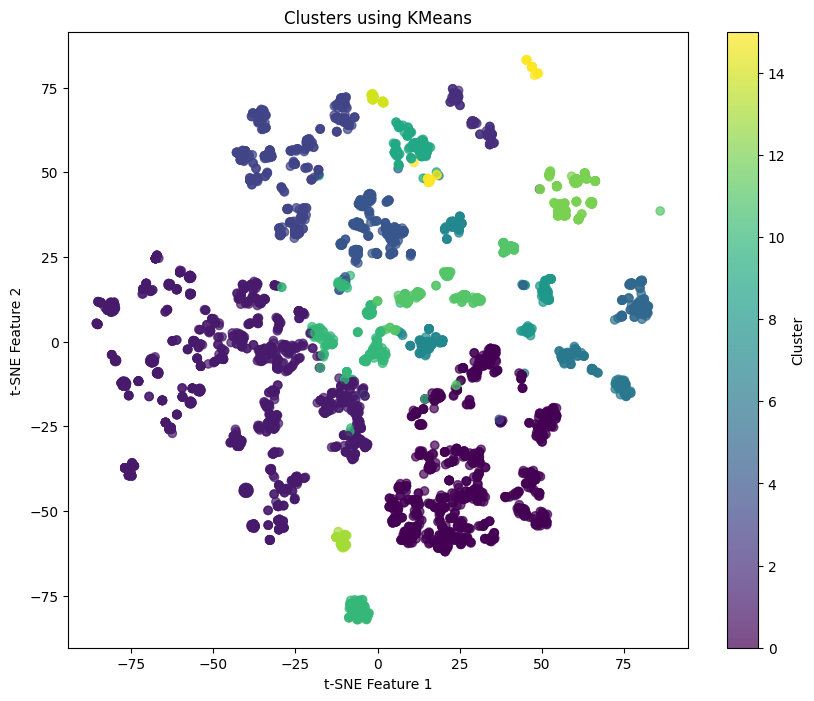

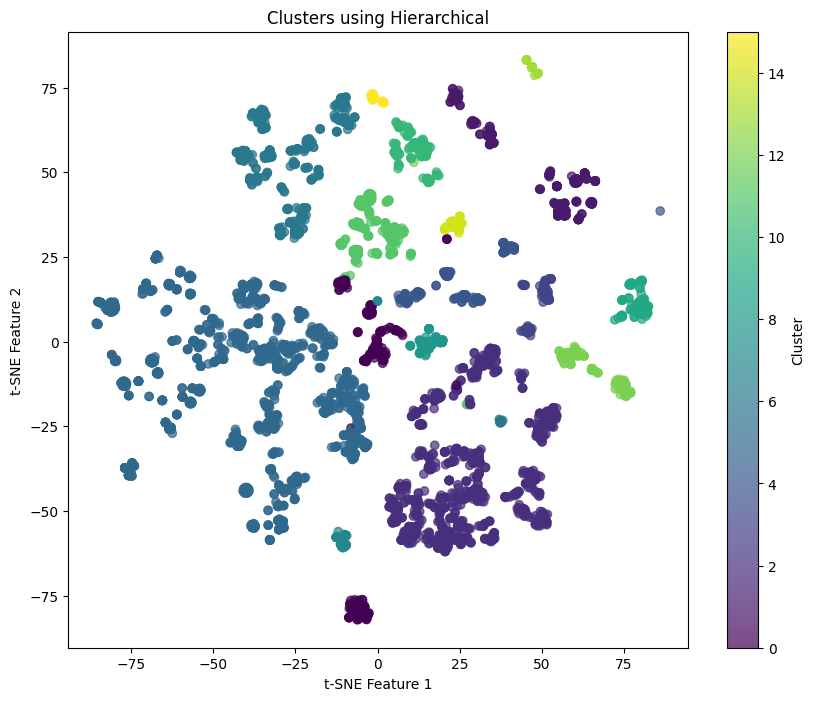

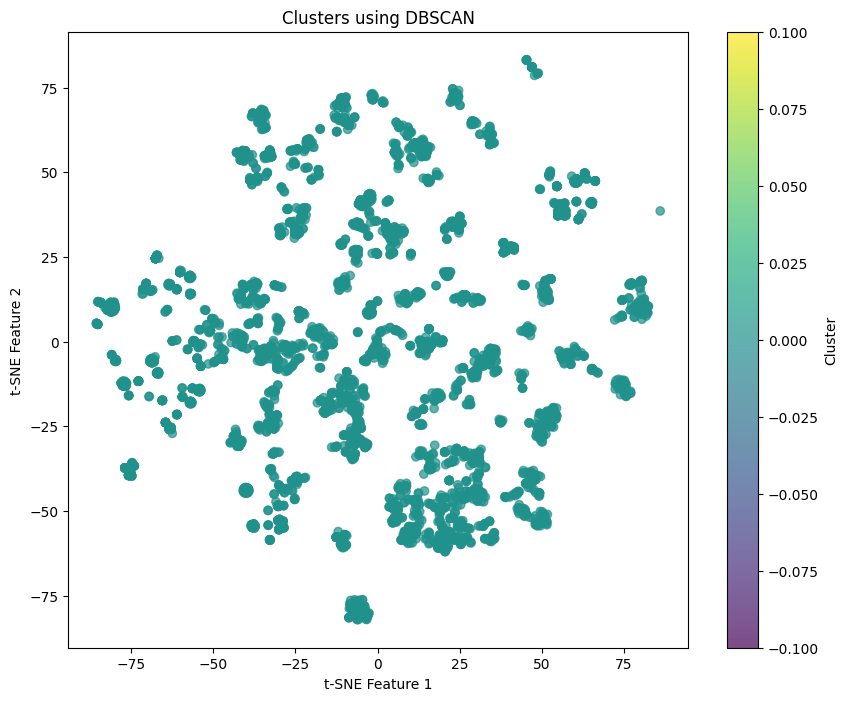

In [9]:
from cluster import cluster
cluster(file=train_easy_df, path=False, n_clusters=16)

# TODO: Rank the clusters
# TODO: Test the dataset
# TODO: Compare with Random selection